In [ ]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", 7 * 53 + 1),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [2]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./doc/devlog/data/temp_synthetic_data.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [3]:
rume.time_frame.start_date

datetime.date(2022, 10, 1)

In [4]:
from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=Poisson(),
)

filter_type = ParticleFilter(num_particles=500)

In [5]:
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.perturbation import Calvetti
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [6]:
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

In [7]:
rng = np.random.default_rng(seed=1)
output = sim.run(rng=rng)

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-10-07 00:00:00 (372 days)
• 500 particles

Simulation completed in 266.99s

Parameters estimated: ['beta', 'xi']


In [8]:
output.particles[0].state, output.particles[0].parameters

(array([[6084142,    9522,  548128,     136]], dtype=int64),
 {'beta': array([0.2432609]), 'xi': array([0.00346481])})

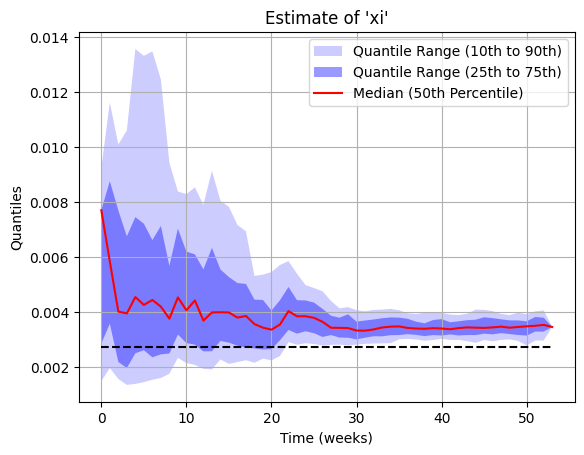

In [9]:
from epymorph.database import NamePattern
import matplotlib.pyplot as plt

key = "xi"
node_index = 0
truth = None

key_quantiles = np.array(output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(
    obs,
    np.broadcast_to(
        rume.params[NamePattern(strata="*", module="*", id="xi")], shape=obs.shape
    ),
    "k--",
)

plt.title(f"Estimate of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


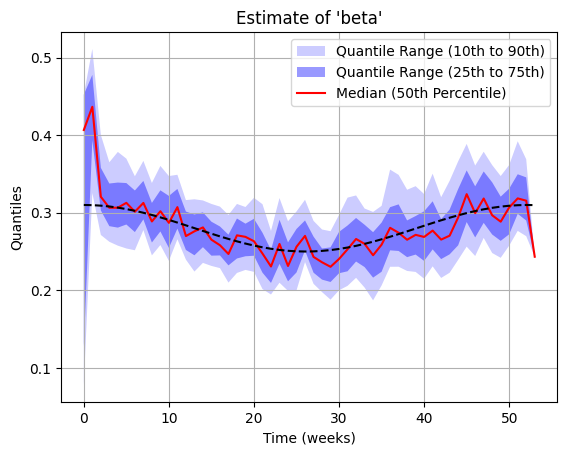

In [10]:
key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(
    obs,
    np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
    "k--",
)

plt.title(f"Estimate of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [11]:
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.perturbation import Calvetti
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [12]:
from typing import List, Dict, Tuple
import numpy as np
from datetime import datetime, timedelta
from epymorph.rume import RUME
from epymorph.parameter_fitting.utils import utils
from epymorph.parameter_fitting.output import ParticleFilterOutput
from epymorph.parameter_fitting.filter.particle import Particle
from epymorph.parameter_fitting.utils.params_perturb import Perturb
from epymorph.parameter_fitting.utils.epymorph_simulation import EpymorphSimulation

In [13]:
class PropagateParticles:
    def __init__(self):
        pass

    def propagate_particles(
        self,
        particles: List[Particle],
        rume: RUME,
        simulation: EpymorphSimulation,
        date: str,
        duration: int,
        model_link: ModelLink,
        params_space: Dict[str, EstimateParameters],
        rng: np.random.Generator,
    ) -> Tuple[List[Particle], List[np.ndarray]]:
        propagated_particles = []
        expected_observations = []

        # Initialize perturbation handler
        params_perturb = Perturb(duration)

        # Propagate each particle through the model
        for particle in particles:
            # Use the particle's state and parameters for propagation
            new_state, observation = simulation.propagate(
                particle.state,
                particle.parameters,
                rume,
                date,
                duration,
                model_link,
                rng,
            )

            # Update the parameters using their dynamics
            new_parameters = {}
            for param, val in particle.parameters.items():
                dynamics = params_space[param].dynamics
                if isinstance(dynamics, GeometricBrownianMotion):
                    new_parameters[param] = params_perturb.gbm(
                        val, dynamics.volatility, rng
                    )
                else:
                    new_parameters[param] = val

            # Create a new particle with the propagated state and updated parameters
            propagated_particles.append(Particle(new_state, new_parameters))

            expected_observations.append(observation)

        return propagated_particles, expected_observations


In [14]:
class ForecastParameters:
    def __init__(
        self,
        initial_particles: List[Particle],
        rume: RUME,
        params_space: Dict[str, EstimateParameters],
        model_link: ModelLink,
        start_date: str,
        duration_weeks: int,
        time_interval: int = 7,
    ):
        self.initial_particles = initial_particles
        self.rume = rume
        self.params_space = params_space
        self.model_link = model_link
        self.start_date = start_date
        self.duration_weeks = duration_weeks
        self.time_interval = time_interval
        self.propagation = PropagateParticles()
        self.rng = np.random.default_rng()
        self.param_quantiles = {}
        self.param_values = {}

    from datetime import datetime, timedelta

    def calculate_end_date(self, start_date: str, duration_weeks: int):
        # Convert start_date string to a datetime object
        start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")

        # Calculate the total duration in days
        total_days = duration_weeks * 7

        # Calculate the end date by adding the total days to the start date
        end_date_obj = start_date_obj + timedelta(days=total_days)

        # Generate the dates list
        dates_list = []
        current_date = start_date_obj

        while current_date <= end_date_obj:
            dates_list.append(current_date.strftime("%Y-%m-%d"))
            current_date += timedelta(days=7)  # Adding 7 days to get the next date

        return end_date_obj.strftime("%Y-%m-%d"), dates_list

    def forecast_params(self):
        simulation = EpymorphSimulation(self.rume, self.start_date)

        end_date, dates_list = self.calculate_end_date(
            self.start_date, self.duration_weeks
        )

        # Prepare containers for storing results
        for key in self.params_space.keys():
            self.param_quantiles[key] = []
            self.param_values[key] = []

        for t in range(len(dates_list)):
            # Propagate particles and update their states
            propagated_particles, expected_observations = (
                self.propagation.propagate_particles(
                    self.initial_particles,
                    self.rume,
                    simulation,
                    dates_list[t],
                    self.time_interval,
                    self.model_link,
                    self.params_space,
                    self.rng,
                )
            )

            particles = propagated_particles.copy()

            for param in particles[0].parameters.keys():
                perturbation = params_space[param].perturbation
                if isinstance(perturbation, Calvetti):
                    param_vals = np.array(
                        [particle.parameters[param] for particle in particles]
                    )
                    param_mean = np.mean(np.log(param_vals), axis=0)
                    param_cov = np.cov(np.log(param_vals), rowvar=False)
                    a = perturbation.a
                    h = np.sqrt(1 - a**2)
                    if len(param_cov.shape) < 2:
                        param_cov = np.broadcast_to(param_cov, shape=(1, 1))
                    rvs = rng.multivariate_normal(
                        (1 - a) * param_mean, h**2 * param_cov, size=len(particles)
                    )
                    for i in range(len(particles)):
                        particles[i].parameters[param] = np.exp(
                            a * np.log(particles[i].parameters[param]) + rvs[i, ...]
                        )

            # Collect parameter values for quantiles and means
            key_values = {key: [] for key in self.param_quantiles.keys()}
            for particle in particles:
                for key in key_values.keys():
                    if key in particle.parameters:
                        key_values[key].append(particle.parameters[key])

            # Store quantiles and means for each parameter
            for key, values in key_values.items():
                if values:
                    self.param_quantiles[key].append(utils.quantiles(np.array(values)))
                    self.param_values[key].append(np.mean(values))

        parameters_estimated = list(self.param_quantiles.keys())

        # Prepare the output object
        out = ParticleFilterOutput(
            len(self.initial_particles),
            parameters_estimated,
            str(rume.time_frame.duration_days) + " days",
            self.param_quantiles,
            self.param_values,
            true_data=np.array([]),
            model_data=np.array([]),
            particles=particles,  # type: ignore
        )

        return out


In [29]:
duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2023-10-07", 7 * 53 + 1),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [30]:
quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [31]:
params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [42]:
sim = ForecastParameters(
    initial_particles=output.particles,
    rume=rume,
    params_space=params_space,
    model_link=model_link,
    start_date="2023-10-07",
    duration_weeks=53,
    time_interval=7,
)

In [43]:
forecast_output = sim.forecast_params()

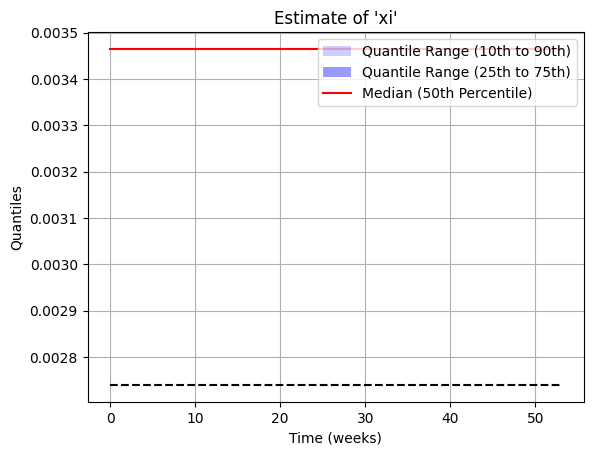

In [44]:
from epymorph.database import NamePattern
import matplotlib.pyplot as plt

key = "xi"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(
    obs,
    np.broadcast_to(
        rume.params[NamePattern(strata="*", module="*", id="xi")], shape=obs.shape
    ),
    "k--",
)

plt.title(f"Estimate of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


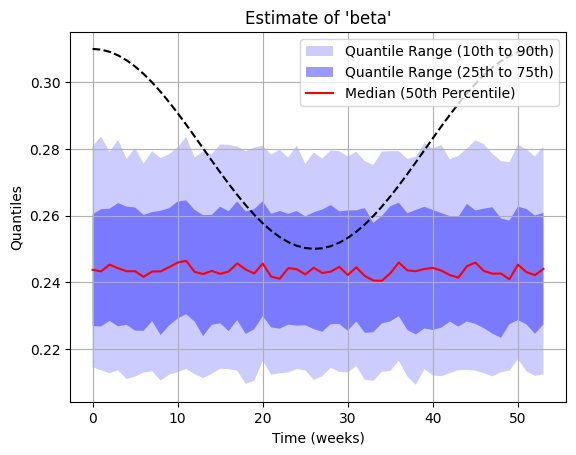

In [45]:
key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(
    obs,
    np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
    "k--",
)

plt.title(f"Estimate of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [ ]:
from epymorph.parameter_forecasting.particle_filer_run import RunPF

In [3]:
particlefilter = RunPF()

In [4]:
simulation_object, pf_output = particlefilter.run()

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-10-07 00:00:00 (372 days)
• 500 particles

Simulation completed in 350.03s

Parameters estimated: ['beta', 'xi']


In [9]:
pf_output

ParticleFilterOutput(num_particles=500, parameters_estimated=['beta', 'xi'], duration='372 days', param_quantiles={'beta': [array([[0.05296632],
       [0.06485688],
       [0.07799908],
       [0.07799908],
       [0.09963757],
       [0.10582245],
       [0.12776673],
       [0.12776673],
       [0.12776673],
       [0.2188253 ],
       [0.3582134 ],
       [0.40665028],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45232978],
       [0.45243424]]), array([[0.20529361],
       [0.23276654],
       [0.29579442],
       [0.32548179],
       [0.36387291],
       [0.38143134],
       [0.39334652],
       [0.40036911],
       [0.41315302],
       [0.4199816 ],
       [0.4262169 ],
       [0.43658903],
       [0.44323894],
       [0.44680419],
       [0.45455991],
       [0.46342583],
       [0.47774935],
       [0.49029268],
       [0.493

In [33]:
import time
from typing import Dict, List, Tuple
import math
import numpy as np
from epymorph.rume import RUME

In [34]:
def propagate_particles(
    particles: List[Particle],
    rume: RUME,
    simulation: EpymorphSimulation,
    date: str,
    duration: int,
    model_link: ModelLink,
    params_space: Dict[str, EstimateParameters],
    rng: np.random.Generator,
) -> Tuple[List[Particle], List[np.ndarray]]:
    """
    Propagates particles through the simulation model.
    """
    propagated_particles = []
    expected_observations = []

    # Initialize perturbation handler
    params_perturb = Perturb(duration)

    # Propagate each particle through the model
    for particle in particles:
        # Use the particle's state and parameters for propagation
        new_state, observation = simulation.propagate(
            particle.state,
            particle.parameters,
            rume,
            date,
            duration,
            model_link,
            rng,
        )

        # Update the parameters using their dynamics
        new_parameters = {}
        for param, val in particle.parameters.items():
            dynamics = params_space[param].dynamics
            if isinstance(dynamics, GeometricBrownianMotion):
                new_parameters[param] = params_perturb.gbm(
                    val, dynamics.volatility, rng
                )
            else:
                new_parameters[param] = val

        # Create a new particle with the propagated state and updated parameters
        propagated_particles.append(Particle(new_state, new_parameters))

        expected_observations.append(observation)

    return propagated_particles, expected_observations

In [ ]:
num_observations = math.ceil(rume.time_frame.duration_days / 7)

date_0 = rume.time_frame.start_date

for t in range(num_observations):
    if t > 0:
        duration = 7  # (dates[t] - dates[t - n]).days
    else:
        duration = 1
    print(f" Itration : {t} Date = {date_0} Duration: {duration}")
    date_0 += timedelta(days=7)


In [53]:
def run(
    num_particles: int,
    rume: RUME,
    params_space: Dict[str, EstimateParameters],
    model_link: ModelLink,
    rng: np.random.Generator,
) -> ParticleFilterOutput:
    start_time = time.time()

    param_quantiles = {}
    param_values = {}

    print("Running Particle Filter simulation")  # noqa: T201
    print(f"• {rume.time_frame.duration_days} days")  # noqa: T201
    print(f"• {num_particles} particles")  # noqa: T201

    num_observations = math.ceil(rume.time_frame.duration_days / 7)

    date_0 = rume.time_frame.start_date

    # Initialize the particles, simulation, and resampling tools
    initializer = ParticleInitializer(num_particles, rume, params_space)
    particles = initializer.initialize_particles(rng)
    simulation = EpymorphSimulation(rume, date_0.strftime("%Y-%m-%d"))

    # Prepare containers for storing results
    for key in params_space.keys():
        param_quantiles[key] = []
        param_values[key] = []

    model_data = []
    data = []

    # Iterate through each time step and perform filtering
    for t in range(num_observations):
        n = 1  # Number of days to look back for the previous observation
        if t > 0:
            duration = 7  # (dates[t] - dates[t - n]).days
        else:
            duration = 1
        print(f" Itration : {t} Date = {date_0} Duration: {duration}")
        # Propagate particles and update their states
        propagated_particles, expected_observations = propagate_particles(
            particles,
            rume,
            simulation,
            date_0.strftime("%Y-%m-%d"),
            duration,
            model_link,
            params_space,
            rng,
        )

        particles = propagated_particles.copy()

        for param in particles[0].parameters.keys():
            perturbation = params_space[param].perturbation
            if isinstance(perturbation, Calvetti):
                param_vals = np.array(
                    [particle.parameters[param] for particle in particles]
                )
                param_mean = np.mean(np.log(param_vals), axis=0)
                param_cov = np.cov(np.log(param_vals), rowvar=False)
                a = perturbation.a
                h = np.sqrt(1 - a**2)
                if len(param_cov.shape) < 2:
                    param_cov = np.broadcast_to(param_cov, shape=(1, 1))
                rvs = rng.multivariate_normal(
                    (1 - a) * param_mean, h**2 * param_cov, size=len(particles)
                )
                for i in range(len(particles)):
                    particles[i].parameters[param] = np.exp(
                        a * np.log(particles[i].parameters[param]) + rvs[i, ...]
                    )

        # Collect parameter values for quantiles and means
        key_values = {key: [] for key in param_quantiles.keys()}
        for particle in particles:
            for key in key_values.keys():
                if key in particle.parameters:
                    key_values[key].append(particle.parameters[key])

        # Store quantiles and means for each parameter
        for key, values in key_values.items():
            if values:
                param_quantiles[key].append(utils.quantiles(np.array(values)))
                param_values[key].append(np.mean(values))

        date_0 += timedelta(days=7)

    parameters_estimated = list(param_quantiles.keys())
    # Calculate total runtime
    total_runtime = time.time() - start_time
    print(f"\nSimulation completed in {total_runtime:.2f}s")  # noqa: T201
    print(f"\nParameters estimated: {parameters_estimated}")  # noqa: T201

    # Prepare the output object
    out = ParticleFilterOutput(
        num_particles,
        parameters_estimated,
        str(rume.time_frame.duration_days) + " days",
        param_quantiles,
        param_values,
        true_data=np.array(data),
        model_data=np.array(model_data),
    )

    return out

In [54]:
from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [55]:
params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [56]:
num_particles = 100

# initializer = ParticleInitializer(num_particles, rume, params_space)

In [57]:
output = run(num_particles, rume, params_space, model_link, np.random.default_rng())

Running Particle Filter simulation
• 372 days
• 100 particles
 Itration : 0 Date = 2022-10-01 Duration: 1
 Itration : 1 Date = 2022-10-08 Duration: 7
 Itration : 2 Date = 2022-10-15 Duration: 7
 Itration : 3 Date = 2022-10-22 Duration: 7
 Itration : 4 Date = 2022-10-29 Duration: 7
 Itration : 5 Date = 2022-11-05 Duration: 7
 Itration : 6 Date = 2022-11-12 Duration: 7
 Itration : 7 Date = 2022-11-19 Duration: 7
 Itration : 8 Date = 2022-11-26 Duration: 7
 Itration : 9 Date = 2022-12-03 Duration: 7
 Itration : 10 Date = 2022-12-10 Duration: 7
 Itration : 11 Date = 2022-12-17 Duration: 7
 Itration : 12 Date = 2022-12-24 Duration: 7
 Itration : 13 Date = 2022-12-31 Duration: 7
 Itration : 14 Date = 2023-01-07 Duration: 7
 Itration : 15 Date = 2023-01-14 Duration: 7
 Itration : 16 Date = 2023-01-21 Duration: 7
 Itration : 17 Date = 2023-01-28 Duration: 7
 Itration : 18 Date = 2023-02-04 Duration: 7
 Itration : 19 Date = 2023-02-11 Duration: 7
 Itration : 20 Date = 2023-02-18 Duration: 7
 It

In [58]:
len(output.param_quantiles["beta"])

54

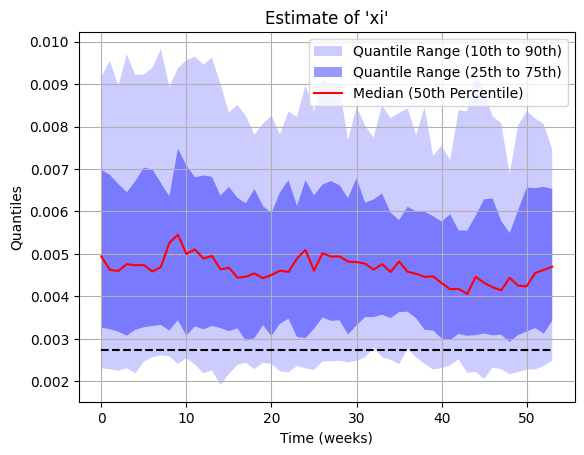

In [59]:
from epymorph.database import NamePattern
import matplotlib.pyplot as plt

key = "xi"
node_index = 0
truth = None

key_quantiles = np.array(output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(
    obs,
    np.broadcast_to(
        rume.params[NamePattern(strata="*", module="*", id="xi")], shape=obs.shape
    ),
    "k--",
)

plt.title(f"Estimate of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


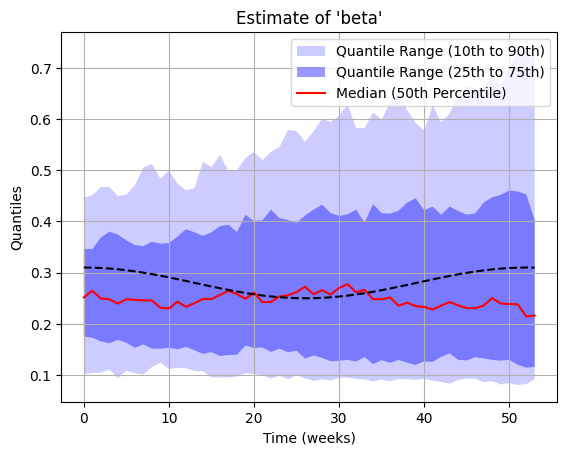

In [62]:
key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(
    obs,
    np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
    "k--",
)

plt.title(f"Estimate of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
